In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def calc_performance(guessed_states, true_states, joint):
    return joint / float(np.maximum(guessed_states, true_states))

In [8]:

def load_data(chess_setup='chess_naive', experiment_setup='_naive_'):
    if chess_setup == 'chess_naive':
        chess_setup = 'chess_naive/path_determination'
        beta_idx = 1
        extra_idx = 2
        iter_idx = -3
    elif chess_setup == 'chessnn':
        beta_idx = 2
        extra_idx = 3
        iter_idx = 0
    else:
        raise ValueError('chess setup not understood')
    performance_dir = {'power': [], 'beta': [], 'extra': [], 'performance': [], 'iter': []}
    npos_dir = ['power_of_6', 'power_of_7', 'power_of_8', 'power_of_9', 'power_of_10', 'power_of_11']
    for npos_d in npos_dir:
        path = 'experiments/data/%s/%s' % (npos_d, chess_setup)
        npos = int(npos_d.split('_')[-1])
        for filename in os.listdir(path):
            f = os.path.join(path, filename)
            # checking if it is a file
            if os.path.isfile(f) and experiment_setup in filename:
                values = np.loadtxt(f).reshape(-1)
                performance = calc_performance(*values)
                beta_val = filename.split('_')[beta_idx]
                iter_val = 0 if experiment_setup == '_naive_' else filename.split('_')[iter_idx]
                if 'chess_naive' in chess_setup:
                    extra_val = True if filename.split('_')[extra_idx] == 'weights' else False
                else:
                    extra_val = filename.split('_')[extra_idx]
                
                tmp_dir = pd.DataFrame(performance_dir)
                mask = np.logical_and(
                    tmp_dir['power'] == npos,
                    np.logical_and(
                        tmp_dir['beta'] == beta_val , 
                        np.logical_and(
                            tmp_dir['extra'] == extra_val,
                            tmp_dir['iter'] == iter_val,
                        )
                    )
                ).to_numpy()
                updated = False
                if len(mask) > 0 and np.any(mask):
                    idx = np.where(mask)[0]
                    updated = True
                    if performance > float(tmp_dir.iloc[idx]['performance']):
                        performance_dir['performance'][int(idx)] = performance  
                if not updated:
                    performance_dir['power'].append(npos)
                    performance_dir['beta'].append(beta_val)
                    performance_dir['extra'].append(extra_val)
                    performance_dir['performance'].append(performance)
                    if experiment_setup == '_naive_':
                        performance_dir['iter'].append(0)
                    else:
                        performance_dir['iter'].append(iter_val)
                
    return pd.DataFrame(performance_dir)

# Naive Approach
## RPM analysis

In [9]:
naive_rpm_frame = load_data(chess_setup='chess_naive', experiment_setup='_naive_')
naive_rpm_frame = naive_rpm_frame.rename(columns={'extra': 'weights'})
naive_rpm_frame

,power,beta,weights,performance,iter
0,6,100,False,0.333333,0
1,6,100,True,0.312500,0
2,6,10,True,0.461538,0
3,6,1000,False,0.285714,0
4,6,1000,True,0.266667,0
5,6,10,False,0.363636,0
6,6,1,True,0.400000,0
7,6,1,False,0.400000,0
8,7,10,True,0.333333,0
9,7,1,False,0.266667,0


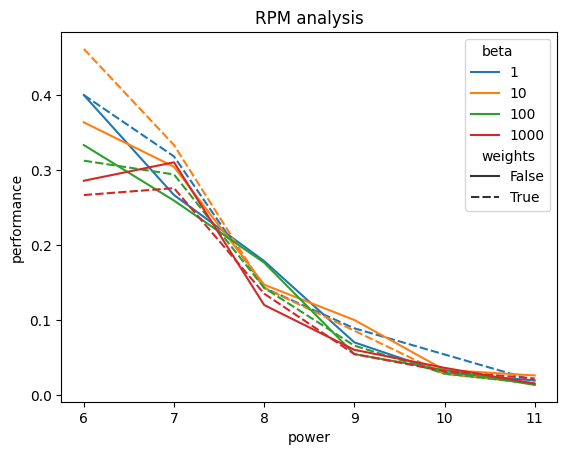

In [10]:
sns.lineplot(
    x='power', 
    y='performance', 
    hue='beta',
    style='weights',
    data=naive_rpm_frame.sort_values(by=['power','beta'])
)
plt.title('RPM analysis')
plt.show()

## Using network structure w/out total reference

In [11]:
naive_noref_frame = load_data(chess_setup='chess_naive', experiment_setup='noref_structure')
naive_noref_frame = naive_noref_frame.rename(columns={'extra': 'weights'})
naive_noref_frame

,power,beta,weights,performance,iter
0,6,100,True,0.333333,3
1,6,1,False,1.000000,15
2,6,10,True,1.000000,22
3,6,100,False,0.714286,21
4,6,100,False,0.666667,23
...,...,...,...,...,...
1001,11,10,True,0.000000,19
1002,11,100,True,0.000000,23
1003,11,100,True,0.000000,3
1004,11,100,False,0.000000,6


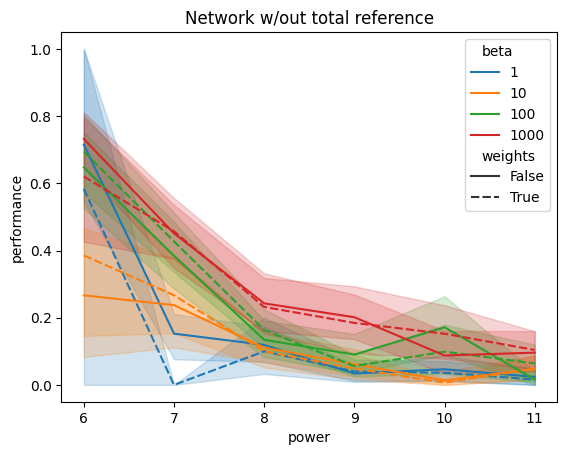

In [12]:
sns.lineplot(
    x='power', 
    y='performance',
    hue='beta',
    style='weights',
    data=naive_noref_frame.sort_values(by=['power','beta'])
)
plt.title('Network w/out total reference')
plt.show()

## Using network with total reference

In [13]:
naive_allref_frame = load_data(chess_setup='chess_naive', experiment_setup='allref_structure')
naive_allref_frame = naive_allref_frame.rename(columns={'extra': 'weights'})
naive_allref_frame

,power,beta,weights,performance,iter
0,6,100,False,1.000000,5
1,6,10,False,1.000000,17
2,6,100,True,0.625000,19
3,6,1,True,1.000000,5
4,6,100,True,0.833333,23
...,...,...,...,...,...
1176,11,10,False,0.600000,7
1177,11,1000,True,1.000000,11
1178,11,100,True,1.000000,16
1179,11,1,False,0.000000,18


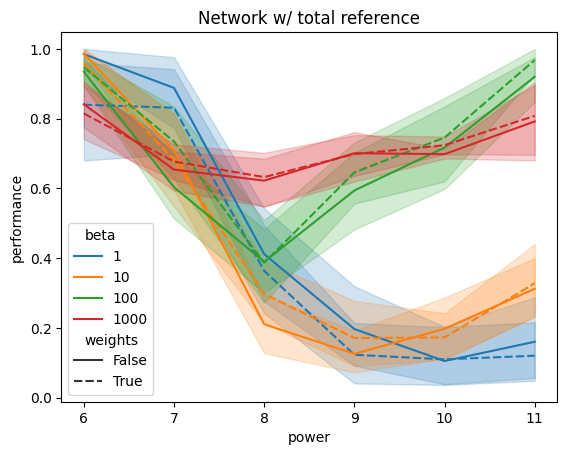

In [14]:
sns.lineplot(
    x='power',
    y='performance',
    hue='beta',
    style='weights',
    data=naive_allref_frame.sort_values(by=['power','beta'])
)
plt.title('Network w/ total reference')
plt.show()

# Statistical Approach

In [15]:
nn_frame = load_data(chess_setup='chessnn', experiment_setup='')
nn_frame = nn_frame.rename(columns={'extra': 'n_sample'})
nn_frame

,power,beta,n_sample,performance,iter
0,6,10,200,1.000000,iter1
1,6,1,20,0.833333,iter2
2,6,1000,20,1.000000,iter2
3,6,100,50,1.000000,iter4
4,6,100,10,1.000000,iter1
...,...,...,...,...,...
595,11,100,10,0.000000,iter1
596,11,10,10,0.000000,iter0
597,11,10,50,0.000000,iter2
598,11,10,50,0.400000,iter3


In [16]:
nn_frame['n_sample'] = nn_frame['n_sample'].astype('int')

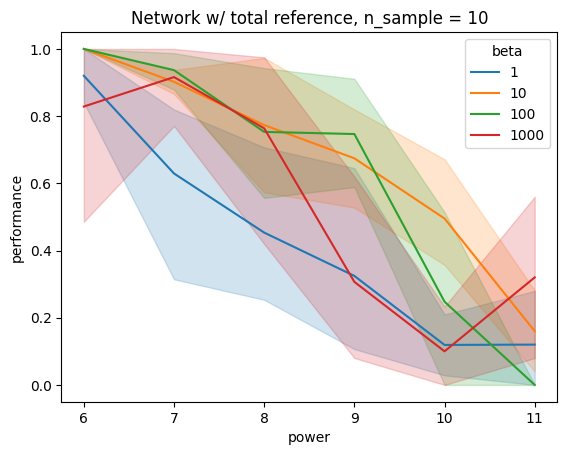

In [18]:
sns.lineplot(
    x='power',
    y='performance', 
    hue='beta',
    data=nn_frame[nn_frame['n_sample'] == 10].sort_values(by=['power','beta'])
)
plt.title('Network w/ total reference, n_sample = 10')
plt.show()

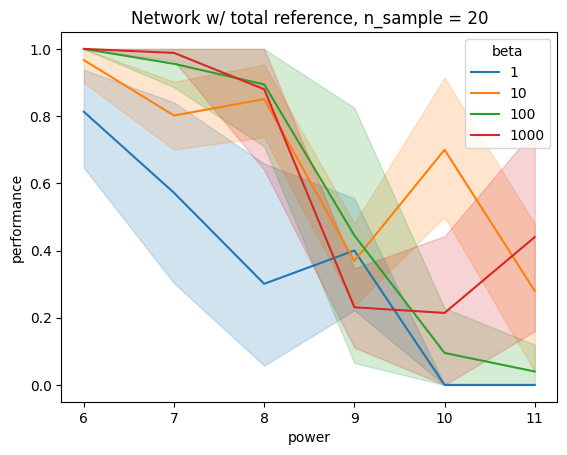

In [19]:
sns.lineplot(
    x='power', 
    y='performance', 
    hue='beta',
    data=nn_frame[nn_frame['n_sample'] == 20].sort_values(by=['power','beta'])
)
plt.title('Network w/ total reference, n_sample = 20')
plt.show()

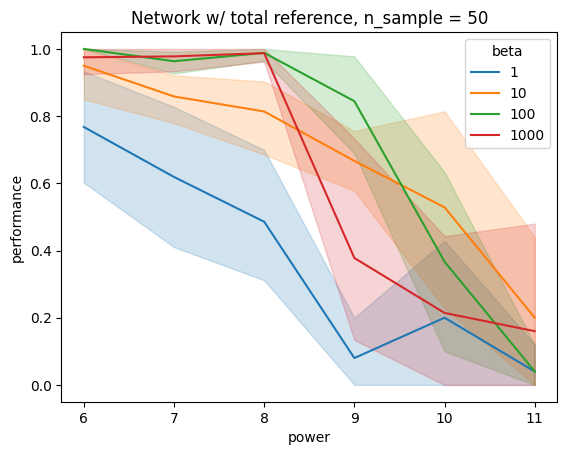

In [20]:
sns.lineplot(
    x='power', 
    y='performance',
    hue='beta',
    data=nn_frame[nn_frame['n_sample'] == 50].sort_values(by=['power','beta'])
)
plt.title('Network w/ total reference, n_sample = 50')
plt.show()

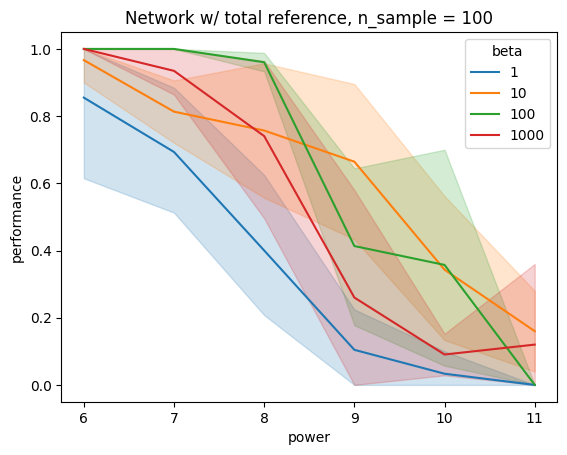

In [21]:
sns.lineplot(
    x='power',
    y='performance',
    hue='beta',
    data=nn_frame[nn_frame['n_sample'] == 100].sort_values(by=['power','beta'])
)
plt.title('Network w/ total reference, n_sample = 100')
plt.show()

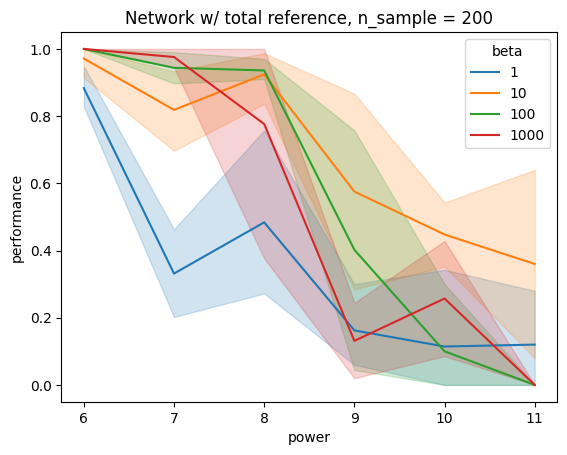

In [22]:
sns.lineplot(
    x='power',
    y='performance', 
    hue='beta',
    data=nn_frame[nn_frame['n_sample'] == 200].sort_values(by=['power','beta'])
)
plt.title('Network w/ total reference, n_sample = 200')
plt.show()